In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import psutil
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1. Load and prepare raw data ---
data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features = ['returns','RSI_14','Volatility_21','MACD','Beta','Alpha','Volume','DMI_minus_14','DMI_plus_14',
            'Calmar_Ratio_21','ATR_14','Open','Close','High','nonfarm_payrolls','real_gdp','cpi','treasury_10y','building_permits']

df_wide = pd.DataFrame()
for feat in features:
    temp = data.pivot(index='Date', columns='Ticker', values=feat)
    temp.columns = [f"{col}_{feat}" for col in temp.columns]
    df_wide = pd.concat([df_wide, temp], axis=1) if not df_wide.empty else temp
df_wide = df_wide.dropna()

returns_cols = [f"{asset}_returns" for asset in assets]
etf_returns = df_wide[returns_cols]

feature_cols = []
for asset in assets:
    for feat in features:
        if feat != 'returns':
            col = f"{asset}_{feat}"
            if col in df_wide.columns:
                feature_cols.append(col)
features_data = df_wide[feature_cols]
scaler_features = StandardScaler()
features_scaled = scaler_features.fit_transform(features_data.values)

# --- 2. Autoencoder Dimensionality Reduction ---
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoded_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoded_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoded_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

input_dim = features_scaled.shape[1]
encoded_dim = 7  # Same as PCA used in your setup
autoencoder = Autoencoder(input_dim, encoded_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)

def train_autoencoder(data, model, epochs=50, batch_size=64, lr=1e-3):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    dataset = torch.utils.data.TensorDataset(torch.tensor(data, dtype=torch.float32))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(epochs):
        total_loss = 0
        for (x_batch,) in dataloader:
            x_batch = x_batch.to(device)
            optimizer.zero_grad()
            encoded, decoded = model(x_batch)
            loss = criterion(decoded, x_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Autoencoder Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader):.6f}")
    model.eval()

train_autoencoder(features_scaled, autoencoder, epochs=50)

with torch.no_grad():
    features_tensor = torch.tensor(features_scaled, dtype=torch.float32).to(device)
    encoded_features, _ = autoencoder(features_tensor)
    features_ae = encoded_features.cpu().numpy()

window_size = 30

# --- 3. Generate dynamic portfolio weights with risk parity ---
def risk_parity_weights(returns_window):
    cov = np.cov(returns_window.T)
    vol = np.sqrt(np.diag(cov))
    inv_vol = 1.0 / (vol + 1e-8)
    weights = inv_vol / inv_vol.sum()
    return weights

def generate_dynamic_weights_with_risk(returns_df, window=window_size):
    weights_list = []
    for i in range(len(returns_df) - 2*window):
        train_w = returns_df.iloc[i:i+window].values
        test_w = returns_df.iloc[i+window:i+2*window]
        mean_returns = test_w.mean()
        mean_returns[mean_returns < 0] = 0
        r_weights = risk_parity_weights(train_w)
        combined = mean_returns * r_weights
        combined[combined < 0] = 0
        if combined.sum() == 0:
            weights = np.ones(len(mean_returns)) / len(mean_returns)
        else:
            weights = combined / combined.sum()
        weights_list.append(weights)
    return np.array(weights_list)

dynamic_weights = generate_dynamic_weights_with_risk(etf_returns, window=window_size)

# --- 4. Sequence Creation ---
def standardize_targets(y):
    scaler = StandardScaler()
    y_scaled = scaler.fit_transform(y.reshape(-1,1)).flatten()
    return y_scaled, scaler

def create_sequences(features_data, returns_data, weights_data, window, clip_sharpe=True):
    X, y_sharpe, y_weights = [], [], []
    limit = len(features_data) - 2*window
    for i in range(limit):
        seq_x = features_data[i:i+window]
        returns_w = returns_data.iloc[i+window:i+2*window]
        mean_ret = returns_w.mean().mean()
        std_ret = returns_w.std().mean()
        sharpe = mean_ret / (std_ret + 1e-6)
        if clip_sharpe:
            sharpe = np.clip(sharpe, -5, 5)
        weight_target = weights_data[i] if i < len(weights_data) else np.ones(len(assets))/len(assets)
        X.append(seq_x)
        y_sharpe.append(sharpe)
        y_weights.append(weight_target)
    y_sharpe_arr = np.array(y_sharpe)
    y_sharpe_scaled, scaler = standardize_targets(y_sharpe_arr)
    return np.array(X), y_sharpe_scaled, np.array(y_weights), scaler

X, y_sharpe_scaled, y_weights, sharpe_scaler = create_sequences(features_ae, etf_returns, dynamic_weights, window_size)

# --- 5. Dataset and DataLoader ---
class PortfolioDataset(Dataset):
    def __init__(self, X, y_sharpe, y_weights):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_sharpe = torch.tensor(y_sharpe, dtype=torch.float32).unsqueeze(1)
        self.y_weights = torch.tensor(y_weights, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y_sharpe[idx], self.y_weights[idx]

X_train, X_test, y_sharpe_train, y_sharpe_test, y_weights_train, y_weights_test = train_test_split(
    X, y_sharpe_scaled, y_weights, test_size=0.2, random_state=42
)
train_dataset = PortfolioDataset(X_train, y_sharpe_train, y_weights_train)
test_dataset = PortfolioDataset(X_test, y_sharpe_test, y_weights_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# --- 6. Bi-LSTM Portfolio Model ---
class BiLSTMPortfolioModel(nn.Module):
    def __init__(self, num_features, n_assets, hidden_dim=64):
        super().__init__()
        self.bi_lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.fc_shared = nn.Linear(hidden_dim*2, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.sharpe_out = nn.Linear(128, 1)
        self.weights_out = nn.Linear(128, n_assets)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        out, _ = self.bi_lstm(x)
        last_step = out[:, -1, :]
        feat = self.relu(self.fc_shared(last_step))
        feat = self.dropout(feat)
        sharpe = self.sharpe_out(feat)
        weights = self.softmax(self.weights_out(feat))
        return sharpe, weights

model = BiLSTMPortfolioModel(num_features=encoded_dim, n_assets=len(assets)).to(device)
criterion_sharpe = nn.MSELoss()
criterion_weights = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- 7. Training Loop ---
epochs = 50
model.train()
start_time = time.time()
cpu_start = psutil.cpu_percent(interval=None)
for epoch in range(epochs):
    epoch_loss = 0
    for batch_x, batch_sharpe, batch_weights in train_loader:
        batch_x, batch_sharpe, batch_weights = batch_x.to(device), batch_sharpe.to(device), batch_weights.to(device)
        optimizer.zero_grad()
        pred_sharpe, pred_weights = model(batch_x)
        loss_sharpe = criterion_sharpe(pred_sharpe, batch_sharpe)
        loss_weights = criterion_weights(pred_weights, batch_weights)
        loss = loss_sharpe * 0.1 + loss_weights
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.6f}")
train_time = time.time() - start_time
cpu_end = psutil.cpu_percent(interval=None)
cpu_usage = cpu_end - cpu_start

# --- 8. Evaluation ---
model.eval()
all_pred_sharpe = []
all_true_sharpe = []
all_pred_weights = []
all_true_weights = []
with torch.no_grad():
    for batch_x, batch_sharpe, batch_weights in test_loader:
        batch_x = batch_x.to(device)
        pred_sharpe, pred_weights = model(batch_x)
        all_pred_sharpe.append(pred_sharpe.cpu().numpy())
        all_pred_weights.append(pred_weights.cpu().numpy())
        all_true_sharpe.append(batch_sharpe.cpu().numpy())
        all_true_weights.append(batch_weights.cpu().numpy())
pred_sharpe_scaled = np.vstack(all_pred_sharpe).flatten()
true_sharpe_scaled = np.vstack(all_true_sharpe).flatten()
pred_weights = np.vstack(all_pred_weights)
pred_weights /= pred_weights.sum(axis=1, keepdims=True)
true_weights = np.vstack(all_true_weights)
pred_sharpe = sharpe_scaler.inverse_transform(pred_sharpe_scaled.reshape(-1,1)).flatten()
true_sharpe = sharpe_scaler.inverse_transform(true_sharpe_scaled.reshape(-1,1)).flatten()
test_returns = etf_returns.iloc[-len(pred_weights):].values
portfolio_returns = np.sum(test_returns * pred_weights, axis=1)
turnover = np.mean(np.sum(np.abs(np.diff(pred_weights, axis=0)), axis=1))

# --- 9. Performance Metrics ---
def sortino_ratio(returns, risk_free=0, periods_per_year=252):
    returns = pd.Series(returns)
    downside = returns[returns < risk_free]
    expected_return = returns.mean() * periods_per_year
    downside_std = downside.std() * np.sqrt(periods_per_year)
    return expected_return / downside_std if downside_std > 0 else np.nan

def calmar_ratio(returns, period_per_year=252):
    returns = pd.Series(returns)
    cumulative = (1 + returns).cumprod()
    annualized_return = cumulative.iloc[-1] ** (period_per_year / len(returns)) - 1
    max_drawdown = ((cumulative.cummax() - cumulative) / cumulative.cummax()).max()
    return annualized_return / max_drawdown if max_drawdown > 0 else np.nan

mse_sharpe = mean_squared_error(true_sharpe, pred_sharpe)
mae_sharpe = mean_absolute_error(true_sharpe, pred_sharpe)
r2_sharpe = r2_score(true_sharpe, pred_sharpe)
sortino = sortino_ratio(portfolio_returns)
calmar = calmar_ratio(portfolio_returns)

def evaluate_portfolio_performance(portfolio_returns):
    portfolio_returns = pd.Series(portfolio_returns).replace([np.inf, -np.inf], np.nan).dropna()
    periods_per_year = 252
    portfolio_values = (1 + portfolio_returns).cumprod()
    peak = portfolio_values.cummax()
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = drawdown.max()
    total_periods = len(portfolio_returns)
    annualized_return = (portfolio_values.iloc[-1]) ** (periods_per_year / total_periods) - 1
    annualized_volatility = portfolio_returns.std() * np.sqrt(periods_per_year)
    mean_return = portfolio_returns.mean() * periods_per_year
    sharpe_ratio = mean_return / annualized_volatility if annualized_volatility > 0 else np.nan
    return {
        'Sharpe Ratio': sharpe_ratio,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Max Drawdown': max_drawdown
    }

performance_metrics = evaluate_portfolio_performance(portfolio_returns)
print("\n--- Portfolio Performance with Bi-LSTM + Autoencoder + Improved Dynamic Weights ---")
print(f"Training time (seconds): {train_time:.2f}")
print(f"CPU usage change (%): {cpu_usage:.2f}\n")
for metric, value in performance_metrics.items():
    if "Return" in metric or "Volatility" in metric or "Drawdown" in metric:
        print(f"- {metric}: {value*100:.2f}%")
    else:
        print(f"- {metric}: {value:.4f}")
print(f"- Sortino Ratio: {sortino:.4f}")
print(f"- Calmar Ratio: {calmar:.4f}")
print(f"- Average Turnover: {turnover:.4f}")
print(f"- Sharpe Prediction MSE: {mse_sharpe:.6f}")
print(f"- Sharpe Prediction MAE: {mae_sharpe:.6f}")
print(f"- Sharpe Prediction R2: {r2_sharpe:.4f}")

# Save weights for plotting or further analysis
weights_df = pd.DataFrame(pred_weights, index=etf_returns.index[-len(pred_weights):], columns=assets)
weights_df.to_csv('final_bilstm_autoencoder_portfolio_weights.csv')
print("Saved predicted portfolio weights to 'final_bilstm_autoencoder_portfolio_weights.csv'.")


Autoencoder Epoch 1/50, Loss: 0.726955
Autoencoder Epoch 2/50, Loss: 0.361631
Autoencoder Epoch 3/50, Loss: 0.281763
Autoencoder Epoch 4/50, Loss: 0.236521
Autoencoder Epoch 5/50, Loss: 0.211539
Autoencoder Epoch 6/50, Loss: 0.194010
Autoencoder Epoch 7/50, Loss: 0.180900
Autoencoder Epoch 8/50, Loss: 0.172220
Autoencoder Epoch 9/50, Loss: 0.165692
Autoencoder Epoch 10/50, Loss: 0.161141
Autoencoder Epoch 11/50, Loss: 0.156504
Autoencoder Epoch 12/50, Loss: 0.152387
Autoencoder Epoch 13/50, Loss: 0.148593
Autoencoder Epoch 14/50, Loss: 0.145884
Autoencoder Epoch 15/50, Loss: 0.143160
Autoencoder Epoch 16/50, Loss: 0.140544
Autoencoder Epoch 17/50, Loss: 0.138299
Autoencoder Epoch 18/50, Loss: 0.136234
Autoencoder Epoch 19/50, Loss: 0.134014
Autoencoder Epoch 20/50, Loss: 0.132407
Autoencoder Epoch 21/50, Loss: 0.130177
Autoencoder Epoch 22/50, Loss: 0.128788
Autoencoder Epoch 23/50, Loss: 0.127003
Autoencoder Epoch 24/50, Loss: 0.125990
Autoencoder Epoch 25/50, Loss: 0.124468
Autoencod

#### Visualization

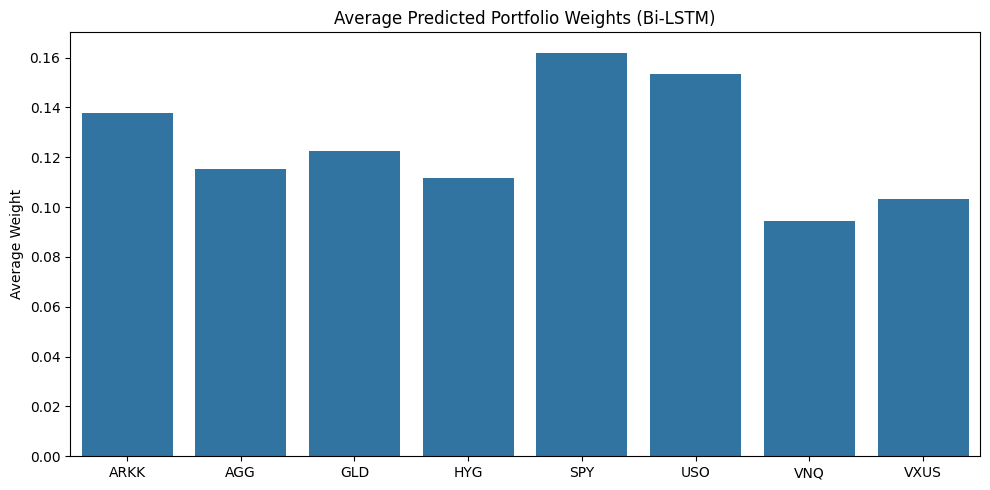

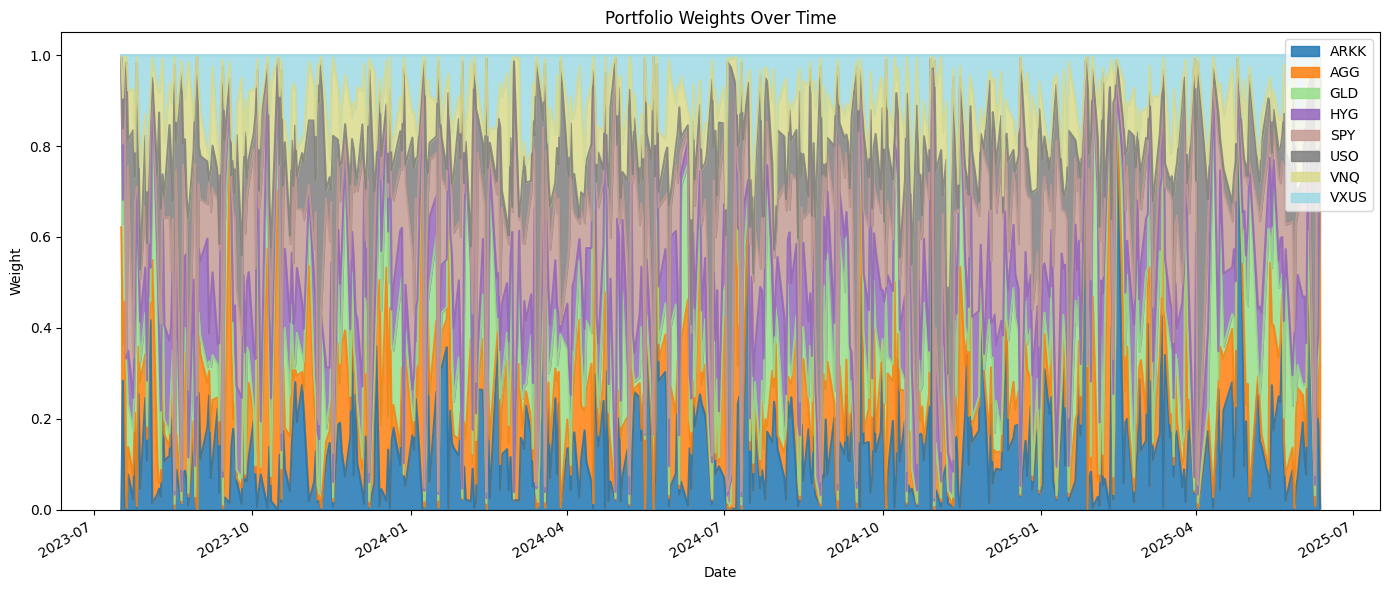

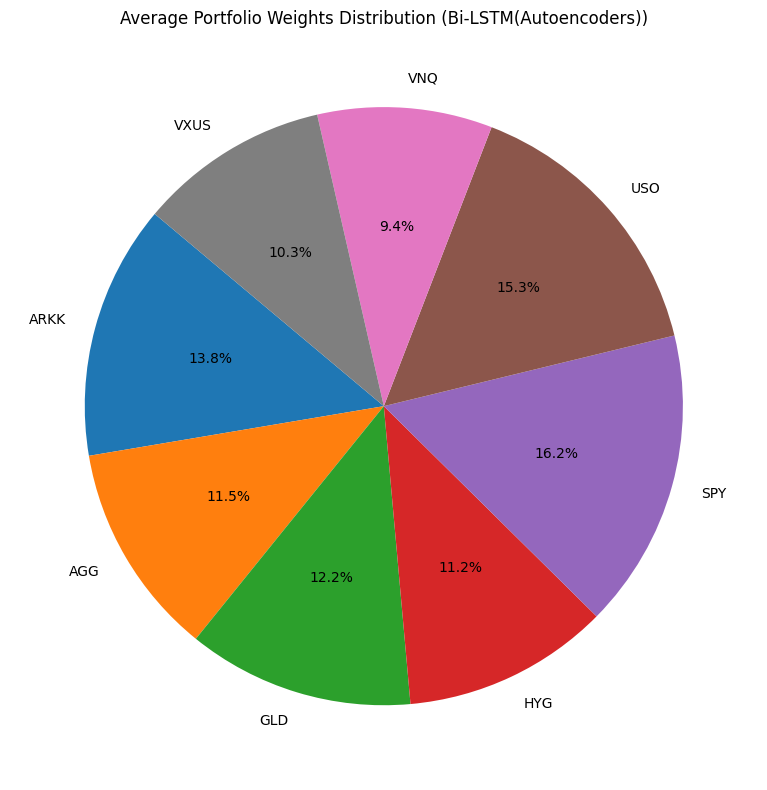

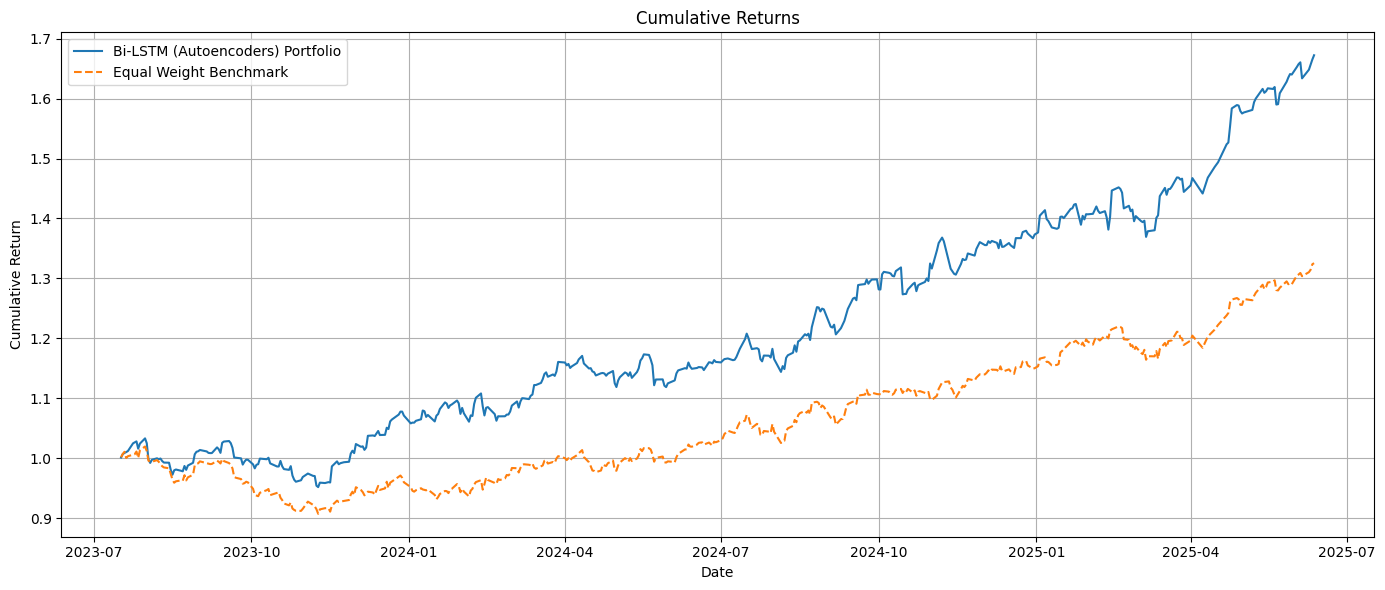

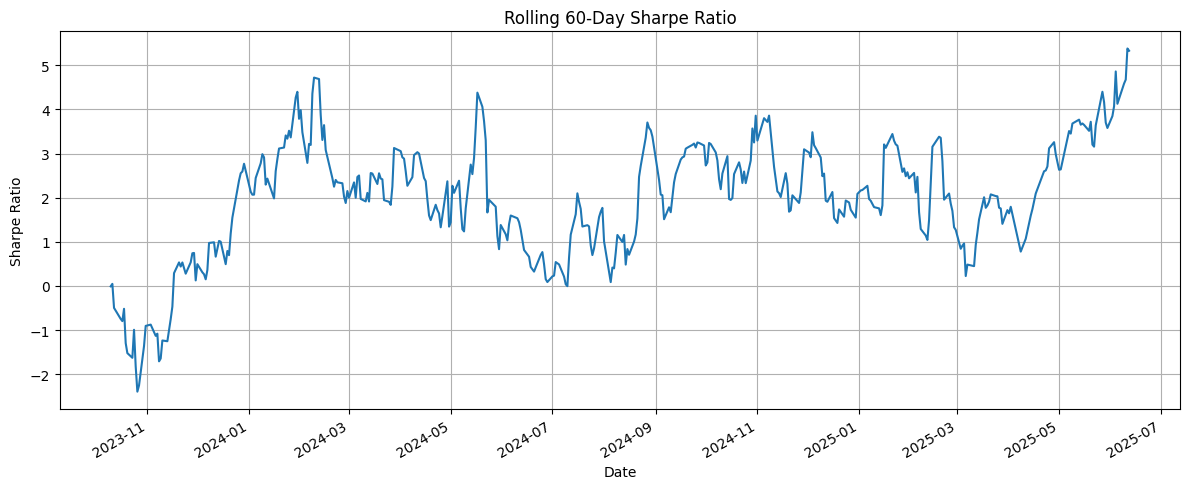

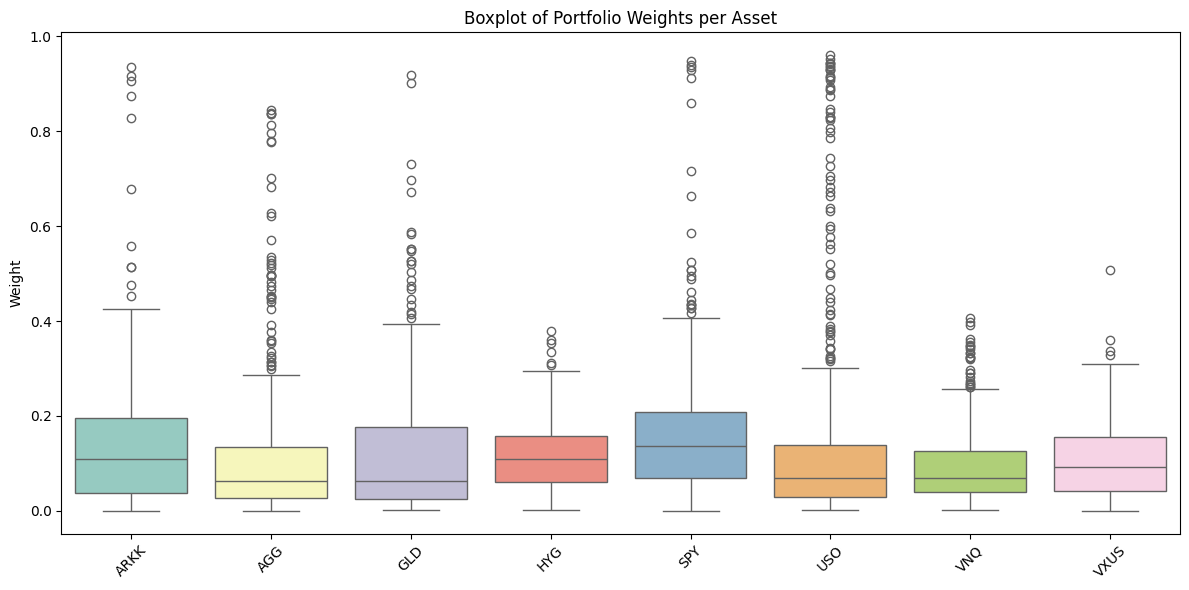

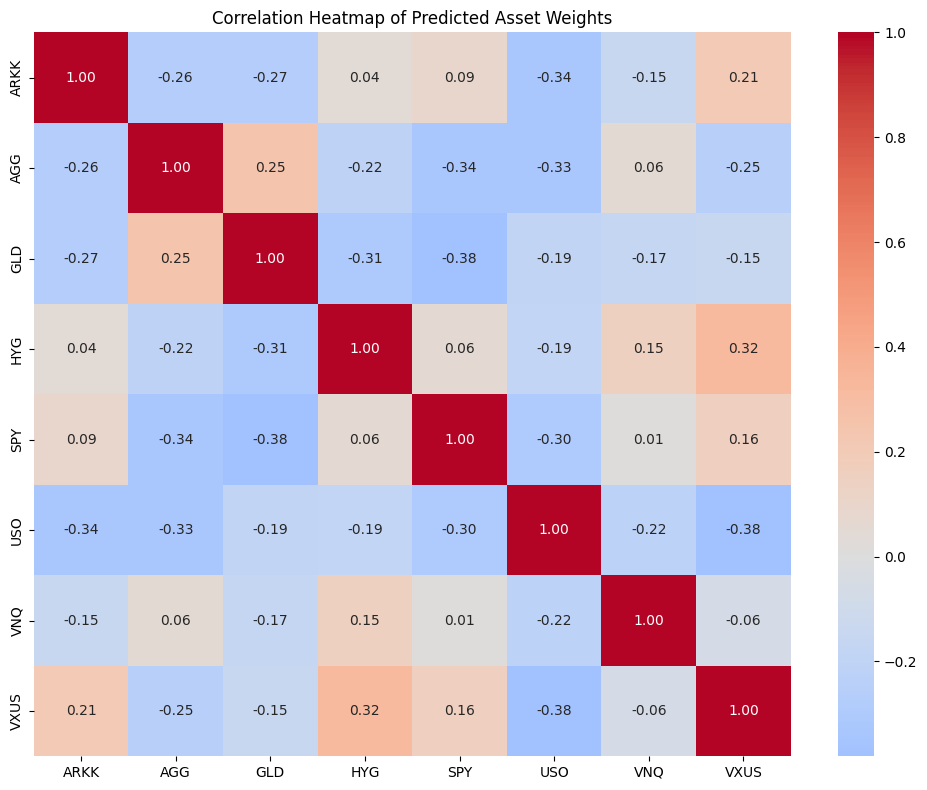

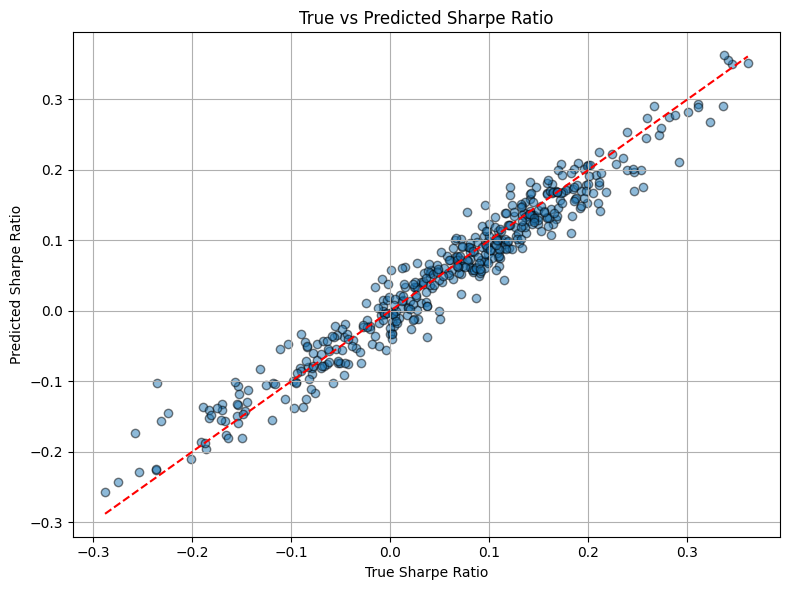

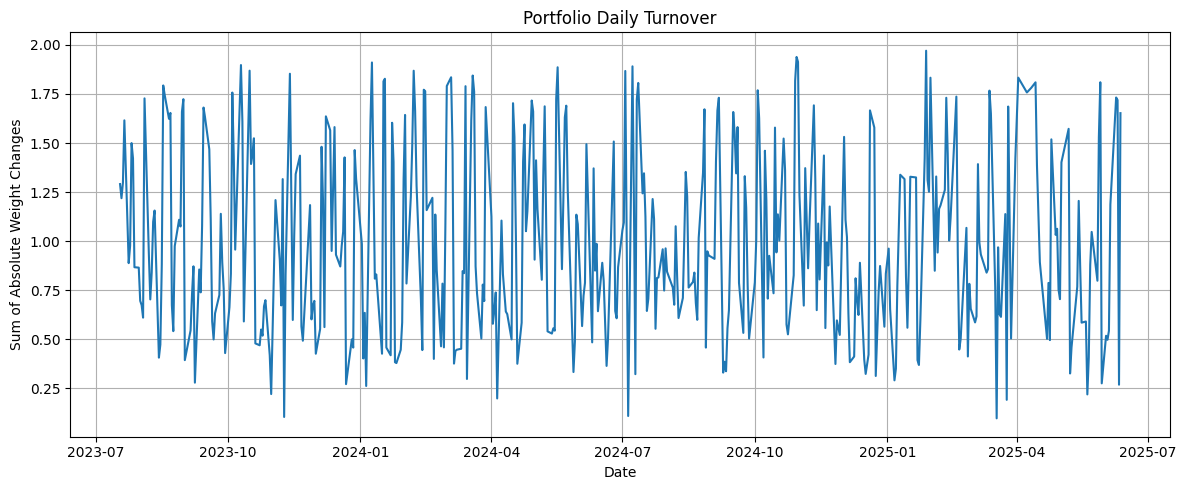

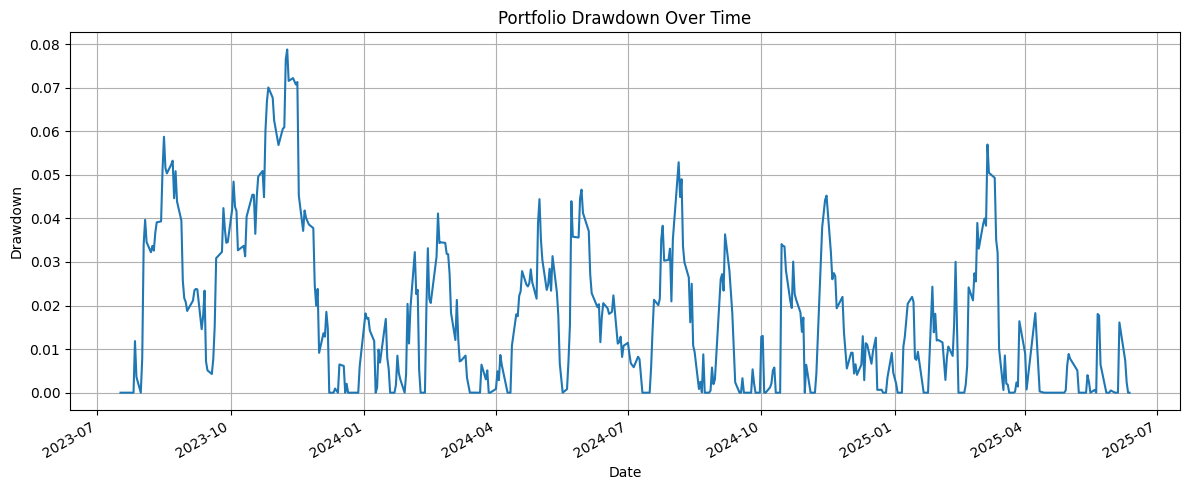

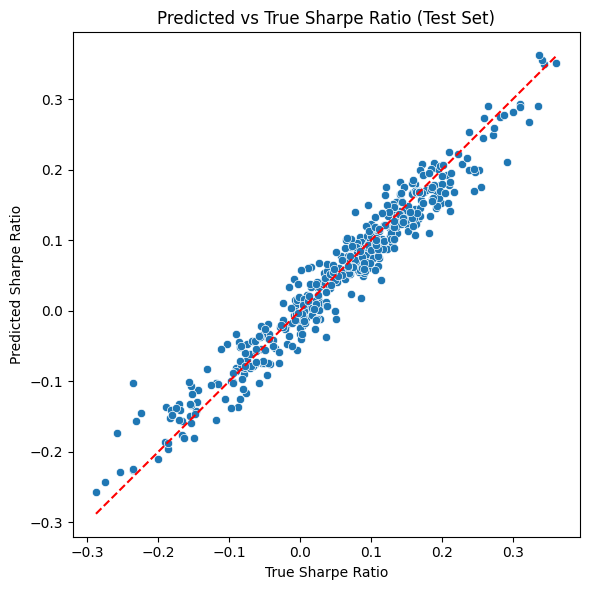

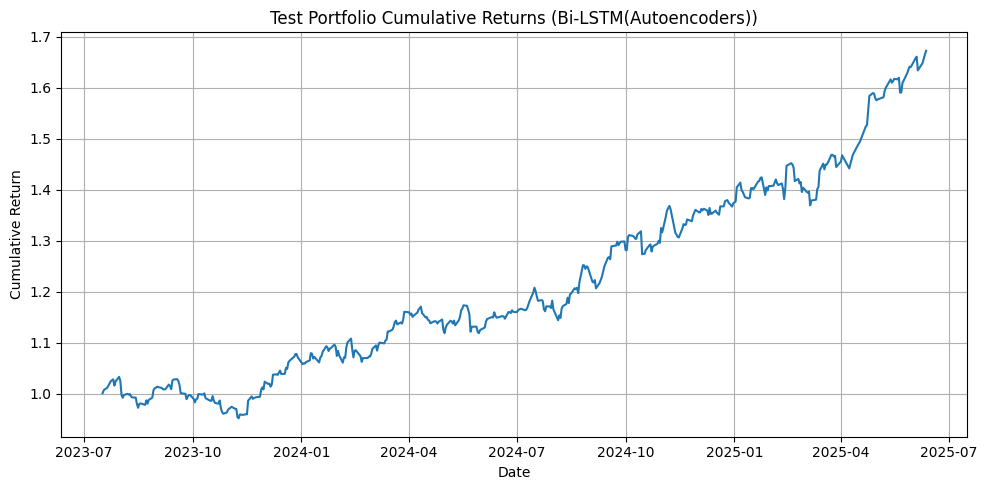

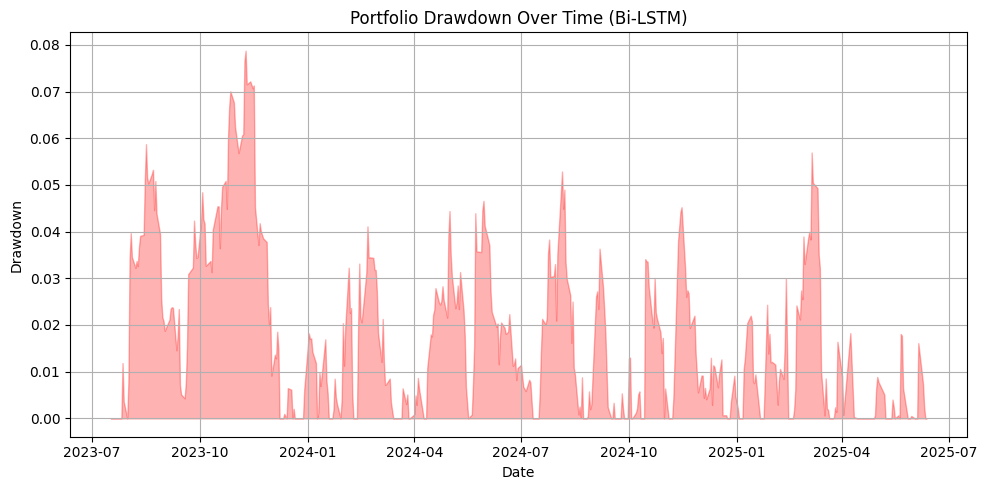

/var/folders/4r/xd1m46rs2r1gx3mmpw3z84pw0000gn/T/ipykernel_28238/600256858.py:196: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='muted')


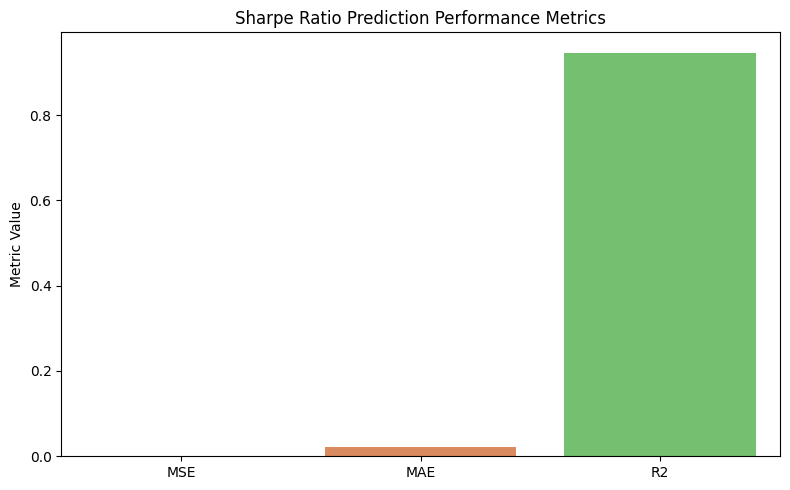

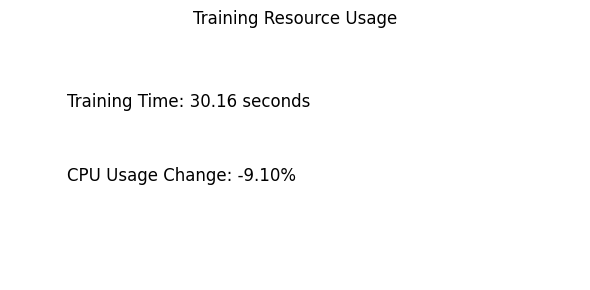

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# assuming the following variables are defined from your Bi-LSTM model and data:
# pred_weights (np.array): predicted portfolio weights, shape (time_steps, n_assets)
# true_sharpe (np.array): true Sharpe ratios for test samples
# pred_sharpe (np.array): predicted Sharpe ratios for test samples
# etf_returns (pd.DataFrame): aligned returns data for test period, shape (time_steps, n_assets)
# assets (list of str): asset tickers or names

# 1. Average Predicted Portfolio Weights (Bar Plot)
avg_weights = pred_weights.mean(axis=0)
plt.figure(figsize=(10,5))
sns.barplot(x=assets, y=avg_weights)
plt.title('Average Predicted Portfolio Weights (Bi-LSTM)')
plt.ylabel('Average Weight')
plt.tight_layout()
plt.show()

# 2. Stacked Area Chart: Portfolio Weights Over Time
pred_weights = pd.DataFrame(pred_weights, columns=assets, index=etf_returns.index[-len(pred_weights):])
pred_weights.plot.area(figsize=(14,6), cmap='tab20', alpha=0.85)
plt.title('Portfolio Weights Over Time')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# # 2. Portfolio Weights Over Time (Line Plot)
# plt.figure(figsize=(12,6))
# for asset in assets:
#     plt.plot(pred_weights.index, pred_weights[asset], label=asset)
# plt.title('Portfolio Weights Over Time (CNN-LSTM)')
# plt.xlabel('Date')
# plt.ylabel('Weight')
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# 3. Pie Chart of Average Portfolio Weights
plt.figure(figsize=(8,8))
plt.pie(avg_weights, labels=assets, autopct='%1.1f%%', startangle=140)
plt.title('Average Portfolio Weights Distribution (Bi-LSTM(Autoencoders))')
plt.tight_layout()
plt.show()

# 3. Cumulative Returns of Portfolio vs Equal Weight Benchmark
portfolio_returns = np.sum(pred_weights * etf_returns.iloc[-len(pred_weights):].values, axis=1)
cumulative_portfolio = (1 + pd.Series(portfolio_returns, index=weights_df.index)).cumprod()

equal_weight_returns = etf_returns.iloc[-len(pred_weights):].mean(axis=1)
cumulative_equal = (1 + equal_weight_returns).cumprod()

plt.figure(figsize=(14,6))
plt.plot(cumulative_portfolio, label='Bi-LSTM (Autoencoders) Portfolio')
plt.plot(cumulative_equal, label='Equal Weight Benchmark', linestyle='--')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Rolling Sharpe Ratio (60-day window)
rolling_window = 60
rolling_returns = pd.Series(portfolio_returns, index=weights_df.index).rolling(rolling_window)
rolling_sharpe = rolling_returns.mean() / (rolling_returns.std() + 1e-6) * np.sqrt(252)

plt.figure(figsize=(12,5))
rolling_sharpe.plot()
plt.title(f'Rolling {rolling_window}-Day Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

# # 5. Histogram: Distribution of All Portfolio Weights
# plt.figure(figsize=(10,6))
# sns.histplot(pred_weights.flatten(), bins=50, kde=True, color='skyblue')
# plt.title('Distribution of Portfolio Weights')
# plt.xlabel('Weight')
# plt.ylabel('Frequency')
# plt.tight_layout()
# plt.show()

# 6. Boxplot: Portfolio Weights Per Asset
plt.figure(figsize=(12,6))
sns.boxplot(data=weights_df, palette='Set3')
plt.title('Boxplot of Portfolio Weights per Asset')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. Correlation Heatmap: Asset Weights Correlation
plt.figure(figsize=(10,8))
corr_weights = weights_df.corr()
sns.heatmap(corr_weights, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Predicted Asset Weights')
plt.tight_layout()
plt.show()

# 8. Scatter Plot: True vs Predicted Sharpe Ratios
plt.figure(figsize=(8,6))
plt.scatter(true_sharpe, pred_sharpe, alpha=0.5, edgecolors='k')
plt.plot([true_sharpe.min(), true_sharpe.max()], [true_sharpe.min(), true_sharpe.max()], 'r--')
plt.xlabel('True Sharpe Ratio')
plt.ylabel('Predicted Sharpe Ratio')
plt.title('True vs Predicted Sharpe Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Daily Portfolio Turnover Over Time
turnover = np.sum(np.abs(np.diff(pred_weights, axis=0)), axis=1)
plt.figure(figsize=(12,5))
plt.plot(weights_df.index[1:], turnover)
plt.title('Portfolio Daily Turnover')
plt.xlabel('Date')
plt.ylabel('Sum of Absolute Weight Changes')
plt.grid(True)
plt.tight_layout()
plt.show()

# # 10. Drawdown Curve
# cum_returns = (1 + pd.Series(portfolio_returns, index=weights_df.index)).cumprod()
# rolling_max = cum_returns.cummax()
# drawdown = (rolling_max - cum_returns) / rolling_max

plt.figure(figsize=(12,5))
drawdown.plot()
plt.title('Portfolio Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Predicted vs True Sharpe Ratio Scatter Plot
plt.figure(figsize=(6,6))
sns.scatterplot(x=true_sharpe, y=pred_sharpe)
min_val = min(min(true_sharpe), min(pred_sharpe))
max_val = max(max(true_sharpe), max(pred_sharpe))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title('Predicted vs True Sharpe Ratio (Test Set)')
plt.xlabel('True Sharpe Ratio')
plt.ylabel('Predicted Sharpe Ratio')
plt.tight_layout()
plt.show()

# 5. Portfolio Cumulative Returns (Test Set)
cum_returns = (1 + pd.Series(portfolio_returns, index=weights_df.index)).cumprod()
plt.figure(figsize=(10,5))
plt.plot(cum_returns.index, cum_returns.values)
plt.title('Test Portfolio Cumulative Returns (Bi-LSTM(Autoencoders))')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Portfolio Drawdown Plot
peak = cum_returns.cummax()
drawdown = (peak - cum_returns) / peak
plt.figure(figsize=(10,5))
plt.fill_between(drawdown.index, drawdown.values, color='red', alpha=0.3)
plt.title('Portfolio Drawdown Over Time (Bi-LSTM)')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.tight_layout()
plt.show()

# # 7. Heatmap of ETF Allocations Over Time
# plt.figure(figsize=(12,6))
# sns.heatmap(weights_df.T, xticklabels=weights_df.index.strftime('%Y-%m-%d'), yticklabels=assets, cmap='viridis')
# plt.title('Heatmap of ETF Allocation Over Time (CNN-LSTM)')
# plt.xlabel('Date')
# plt.ylabel('ETF')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# 2. Bar Plot of Performance Metrics (MSE, MAE, R²)
metrics = ['MSE', 'MAE', 'R2']
values = [mse_sharpe, mae_sharpe, r2_sharpe]

plt.figure(figsize=(8,5))
sns.barplot(x=metrics, y=values, palette='muted')
plt.title('Sharpe Ratio Prediction Performance Metrics')
plt.ylabel('Metric Value')
plt.tight_layout()
plt.show()

# 3. Display Training Time and CPU Usage as Text Plot
plt.figure(figsize=(6,3))
plt.axis('off')
plt.text(0.1, 0.7, f'Training Time: {train_time:.2f} seconds', fontsize=12)
plt.text(0.1, 0.4, f'CPU Usage Change: {cpu_usage:.2f}%', fontsize=12)
plt.title('Training Resource Usage')
plt.tight_layout()
plt.show()


#### Pytorch Model Layer Summary

In [5]:
import torch
from torchinfo import summary
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoded_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoded_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoded_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Example usage for layer summary:

input_dim = 19  
encoded_dim = 7

model_autoencoder = Autoencoder(input_dim=input_dim, encoded_dim=encoded_dim)

# Print model summary with batch size 32
summary(model_autoencoder, input_size=(32, input_dim))


Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [32, 7]                   --
├─Sequential: 1-1                        [32, 7]                   --
│    └─Linear: 2-1                       [32, 128]                 2,560
│    └─ReLU: 2-2                         [32, 128]                 --
│    └─Linear: 2-3                       [32, 7]                   903
├─Sequential: 1-2                        [32, 19]                  --
│    └─Linear: 2-4                       [32, 128]                 1,024
│    └─ReLU: 2-5                         [32, 128]                 --
│    └─Linear: 2-6                       [32, 19]                  2,451
Total params: 6,938
Trainable params: 6,938
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.03
Estimated Total Size (MB): 0.10